# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Brain_Tumor'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import ConcatDataset

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models
import torch.nn.functional as F


import matplotlib.pyplot as plt
import numpy as np

In [ ]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 50

print('using device:', device)

using device: cuda


# Get Data and Data Augmentation

In [ ]:

data_dir_train = './Brain tumor MRI 4 classes BIG/Training/'
data_dir_test = './Brain tumor MRI 4 classes BIG/Testing/'



# Data Augmentation
transform = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
    # T.Normalize([0.2456, 0.2457, 0.2459], [0.2251, 0.2251, 0.2251]),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# Add horizontal flip to each image and add to dataset
aug_transform = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
    # T.Normalize([0.2456, 0.2457, 0.2459], [0.2251, 0.2251, 0.2251]),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    # T.RandomVerticalFlip(p = 1.0),
    T.RandomHorizontalFlip(p = 1.0),
])



dataset = dset.ImageFolder(data_dir_train, transform=transform)
aug_dataset = dset.ImageFolder(data_dir_train, transform=aug_transform)


# combine original dataset and augmented dataset
combined_training_dataset = ConcatDataset([dataset, aug_dataset]) # total size = 5740, 6614  4950(3 classes) 11424

test_dataset = dset.ImageFolder(data_dir_test, transform=transform) # 1311

indexes = np.arange(11424)
indexes_test =np.arange(1311)

np.random.seed(42)
np.random.shuffle(indexes)
np.random.shuffle(indexes_test)

# num_train = 9424
loader_train = torch.utils.data.DataLoader(combined_training_dataset, batch_size=32,
                                           sampler=sampler.SubsetRandomSampler(indexes[:9424],
                                                                               generator=torch.Generator().manual_seed(42)))
# num_val = 2000
loader_val = torch.utils.data.DataLoader(combined_training_dataset, batch_size=32,
                                         sampler=sampler.SubsetRandomSampler(indexes[-2000:],
                                                                             generator=torch.Generator().manual_seed(42)))

loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                          sampler=sampler.SubsetRandomSampler(indexes_test,
                                                                             generator=torch.Generator().manual_seed(42)))

In [ ]:
len(combined_test_dataset)

578

In [ ]:
# len(combined_training_dataset)

6614

In [ ]:
# # Calculate mean and std for normalization
# mean = torch.tensor(np.array([0,0,0]))
# std = torch.tensor(np.array([0,0,0]))
# nb_samples = 0
# for data, label in dataloader:
#     mean = torch.add(mean, data.mean([2,3]))
#     std = torch.add(std, data.std([2,3]))
#     nb_samples += 1
# mean /= nb_samples
# std /= nb_samples
# print(nb_samples)
# print(mean)
# print(std)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
tensor(0)


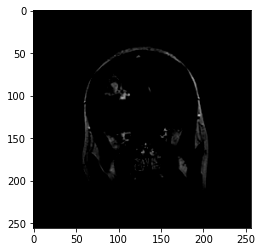

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
tensor(0)


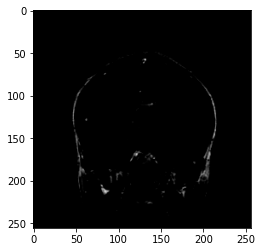

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
tensor(0)


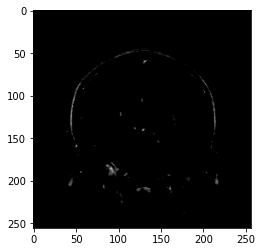

In [ ]:
# Run this to test your data loader
images, labels = next(iter(loader_ori))


print(images[0].size())
print(labels[0])
plt.imshow(images[0].permute(1, 2, 0))
plt.show()

print(images[1].size())
print(labels[1])
plt.imshow(images[1].permute(1, 2, 0))
plt.show()

print(images[2].size())
print(labels[2])
plt.imshow(images[2].permute(1, 2, 0))
plt.show()

# note labels:
# tensor(0) means brain tumor
# tensor(1) means healthy
# refer to file orders

In [ ]:
counter = 0
# health = 0
# tumor = 0
class1 =0
class2 =0
class3 =0
class4 =0

while counter < 2:
  images, labels = next(iter(loader_train))

  for i in range(len(images)):

      if labels[i] == 0:
        class1 += 1

      if labels[i] == 1:
        class2 += 1

      if labels[i] == 2:
        class3 += 1

      if labels[i] == 3:
        class4 += 1

  # print("Num of tumors: ", tumor)
  # print("Num of health: ", health)

  print("class1: ", class1)
  print("class2: ", class2)
  print("class3: ", class3)
  print("class4: ", class4)

  counter +=1



# CNN Model From Scratch

In [ ]:
def check_accuracy(loader, model, mode):

    if mode == 'Train':
        print('Checking accuracy on training set')
    elif mode == 'Validation':
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        # counter = 0
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            # print(counter)
            # counter += 1
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))


    return acc

In [ ]:
def train(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU

    train_acc = []
    val_acc = []

    losses = []

    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1) # new #############################################

    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):

            print(t)

            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                train = check_accuracy(loader_train, model, 'Train')
                val = check_accuracy(loader_val, model, 'Validation')
                train_acc.append(train)
                val_acc.append(val)
                losses.append(loss.item())
                print()

        # scheduler.step() ###################################################3 new

        # print('Epoch %d, loss = %.4f' % (e, loss.item()))
        # train = check_accuracy(loader_train, model, 'Train')
        # val = check_accuracy(loader_val, model, 'Validation')
        # train_acc.append(train)
        # val_acc.append(val)
        # print()

    plt.title('Accuracy')
    plt.plot(np.arange(0,1250,50),train_acc, '-o', label='train')
    plt.plot(np.arange(0,1250,50),val_acc, '-o', label='val')
    plt.xlabel('Iterations')
    plt.legend(loc='lower right')
    plt.show()

    plt.title('Training Loss')
    plt.plot(np.arange(0,1250,50),losses)
    plt.xlabel('Iterations')
    plt.show()


In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [ ]:
model = None
optimizer = None

# channel_1 = 8
# channel_2 = 16
# channel_3 = 32
# channel_4 = 64
channel_1 = 32
channel_2 = 32
channel_3 = 64
channel_4 = 64
h1 = 150
# h2 = 150

# learning_rate = 9e-3
learning_rate = 0.001

model = nn.Sequential(

    nn.Conv2d(3, channel_1, 3, padding=1, bias = True),
    nn.ReLU(),
    nn.BatchNorm2d(channel_1),
    nn.MaxPool2d(2, stride= 2),
    nn.Conv2d(channel_1, channel_2, 3, padding=1, bias = True),
    nn.ReLU(),
    nn.BatchNorm2d(channel_2),
    nn.MaxPool2d(2, stride= 2),
    nn.Conv2d(channel_2, channel_3, 3, padding=1, bias = True),
    nn.ReLU(),
    nn.BatchNorm2d(channel_3),
    nn.MaxPool2d(2, stride= 2),
    nn.Conv2d(channel_3, channel_4, 3, padding=1, bias = True),
    nn.ReLU(),
    nn.BatchNorm2d(channel_4),
    nn.MaxPool2d(2, stride= 2),
    Flatten(),
    nn.Linear(channel_4*16*16, h1),
    nn.BatchNorm1d(h1),
    nn.ReLU(),
    nn.Dropout(p= 0.1),
    # nn.Linear(h1, h2),
    # nn.BatchNorm1d(h2),
    # nn.ReLU(),
    # nn.Dropout(p= 0.1),
    # nn.Linear(h2, 2),
    nn.Linear(h1, 4), ### 4 classes
    nn.Softmax()
)

# channel_1 = 10
# channel_2 = 20
# h1 = 150
# h2 = 150

# # learning_rate = 9e-3
# learning_rate = 5e-4

# model = nn.Sequential(

#     nn.Conv2d(3, channel_1, 3, padding=1, bias = True),
#     nn.ReLU(),
#     nn.BatchNorm2d(channel_1),
#     nn.MaxPool2d(3, stride= 1, padding= 1),
#     nn.Conv2d(channel_1, channel_2, 3, padding=1, bias = True),
#     nn.ReLU(),
#     nn.BatchNorm2d(channel_2),
#     nn.MaxPool2d(3, stride= 1, padding= 1),
#     Flatten(),
#     nn.Linear(channel_2*256*256, h1),
#     nn.BatchNorm1d(h1),
#     nn.ReLU(),
#     nn.Dropout(p= 0.1),
#     nn.Linear(h1, h2),
#     nn.BatchNorm1d(h2),
#     nn.ReLU(),
#     nn.Dropout(p= 0.1),
#     # nn.Linear(h2, 2),
#     nn.Linear(h2, 4), ### 4 classes
#     nn.Softmax()
# )

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

## 4 classes

In [ ]:
train(model, optimizer, epochs = 4)

0
Iteration 0, loss = 1.3938
Checking accuracy on training set


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Got 2464 / 9424 correct (26.15)
Checking accuracy on validation set
Got 525 / 2000 correct (26.25)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Iteration 50, loss = 1.0269
Checking accuracy on training set
Got 6349 / 9424 correct (67.37)
Checking accuracy on validation set
Got 1339 / 2000 correct (66.95)

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Iteration 100, loss = 1.0367
Checking accuracy on training set
Got 7897 / 9424 correct (83.80)
Checking accuracy on validation set
Got 1644 / 2000 correct (82.20)

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
Iteration 150, loss = 0.9589
Checking accuracy on training set
Got 8115 / 9424 co

In [ ]:
# test model
best_model = model
check_accuracy(loader_test, best_model, 'Test')

0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iteration 0, loss = 1.3647
Checking accuracy on training set
Got 2167 / 9424 correct (22.99)
Checking accuracy on validation set
Got 475 / 2000 correct (23.75)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Iteration 50, loss = 0.9574
Checking accuracy on training set
Got 7019 / 9424 correct (74.48)
Checking accuracy on validation set
Got 1465 / 2000 correct (73.25)

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Iteration 100, loss = 0.8870
Checking accuracy on training set
Got 8162 / 9424 correct (86.61)
Checking accuracy on validation set
Got 1708 / 2000 correct (85.40)

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
Iteration 150, loss 

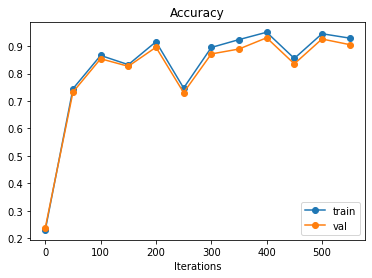

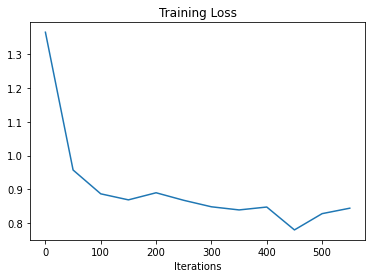

In [ ]:
train(model, optimizer, epochs = 2)

In [ ]:
# test model
best_model = model
check_accuracy(loader_test, best_model, 'Test')

Checking accuracy on test set


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Got 1180 / 1311 correct (90.01)


0.9000762776506483

In [ ]:
# test model
best_model = model
check_accuracy(loader_test, best_model, 'Test')

Checking accuracy on test set


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Got 1169 / 1311 correct (89.17)


0.8916857360793288

# Pretrained Models

## ResNet

In [ ]:
model = models.resnet34(pretrained=True)

num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
model.fc = nn.Linear(num_ftrs, 4) ### 4 classes
model = model.to(device)

# learning_rate = 0.001
# learning_rate = 0.008

learning_rate = 0.0005

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

## 4 classes

0
Iteration 0, loss = 1.6468
Checking accuracy on training set
Got 3279 / 9424 correct (34.79)
Checking accuracy on validation set
Got 720 / 2000 correct (36.00)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Iteration 50, loss = 0.4626
Checking accuracy on training set
Got 7774 / 9424 correct (82.49)
Checking accuracy on validation set
Got 1637 / 2000 correct (81.85)

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Iteration 100, loss = 0.2725
Checking accuracy on training set
Got 8690 / 9424 correct (92.21)
Checking accuracy on validation set
Got 1820 / 2000 correct (91.00)

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
Iteration 150, los

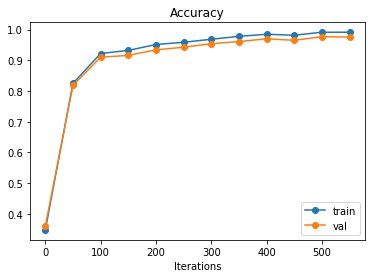

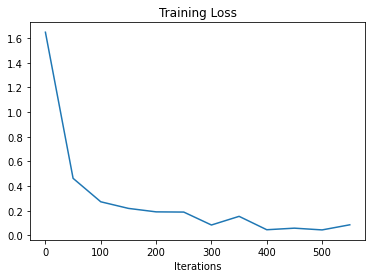

In [ ]:
train(model, optimizer, epochs= 2)

In [ ]:
# test model
best_model = model
check_accuracy(loader_test, best_model, 'Test')

Checking accuracy on test set
Got 1278 / 1311 correct (97.48)


0.9748283752860412

## VGG-19

In [ ]:
model = models.vgg19_bn(pretrained=True)
# model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 4) ### 4 classes
model = model.to(device)

# learning_rate = 0.001
learning_rate = 0.0005
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # weight decay

# adaptive learning rate (schedule)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

## 4 classes

In [ ]:
train(model, optimizer, epochs= 2)

0
Iteration 0, loss = 1.4142
Checking accuracy on training set
Got 2144 / 9424 correct (22.75)
Checking accuracy on validation set
Got 495 / 2000 correct (24.75)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Iteration 50, loss = 0.6270
Checking accuracy on training set
Got 8055 / 9424 correct (85.47)
Checking accuracy on validation set
Got 1691 / 2000 correct (84.55)

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Iteration 100, loss = 0.1797
Checking accuracy on training set
Got 8514 / 9424 correct (90.34)
Checking accuracy on validation set
Got 1794 / 2000 correct (89.70)

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
Iteration 150, los

In [ ]:
# test model
best_model = model
check_accuracy(loader_test, best_model, 'Test')

Checking accuracy on test set
Got 1275 / 1311 correct (97.25)


0.9725400457665904